# 📦 Step 1: Imports & Setup

In [1]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler, SequentialSampler
from torch import optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import MultiStepLR
from PIL import Image, UnidentifiedImageError
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import numpy as np

In [8]:
data_dir = './data/train_images'
cropped_dir = './data/cropped_images'

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(image_size=160, margin=0, min_face_size=20, keep_all=False, thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True, device=device)
facenet_model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

batch_size = 16
workers = 0 if os.name == 'nt' else 4

trans = transforms.Compose([
  np.float32,
  transforms.ToTensor(),
  fixed_image_standardization
])

facenet_model = InceptionResnetV1(
  classify=False,
  pretrained='vggface2'
).eval().to(device)

# 🧪 Step 2: Training Loop

### ✂️ Run & Crop Image using MTCNN on the dataset

In [ ]:
# Step 1: Create clean list of valid images
valid_samples = []
for path, _ in datasets.ImageFolder(data_dir).samples:
  try:
    with Image.open(path) as img:
      # img = img.convert("RGB") 
      img.verify()
    # Create equivalent path in cropped folder
    cropped_path = path.replace(data_dir, cropped_dir)
    os.makedirs(os.path.dirname(cropped_path), exist_ok=True)
    valid_samples.append((path, cropped_path))
  except (UnidentifiedImageError, OSError) as e:
    print(f"[Skip] Bad image: {path} - {e}")

# Step 2: Load dataset with only valid images
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = valid_samples  # Override sample list

# Step 3: Create DataLoader
loader = DataLoader(
  dataset,
  num_workers=workers,
  batch_size=batch_size,
  collate_fn=training.collate_pil
)

# Step 4: Run MTCNN safely
for i, (x, y) in enumerate(loader):
  try:
    valid_batch = [(img, target) for img, target in zip(x, y) if img is not None and isinstance(target, str)]
    if not valid_batch:
      print(f"\n[Skip] Batch {i+1}: all images invalid.")
      continue
    imgs, targets = zip(*valid_batch)
    mtcnn(list(imgs), save_path=list(targets))
  except Exception as e:
    print(f"\n[Error] Skipped batch {i+1}: {e}")
  else:
    print('\r第 {} 批，共 {} 批'.format(i + 1, len(loader)), end='')

[Skip] Bad image: ./data/train_images\ariana_grande\image_39.jpg - cannot identify image file './data/train_images\\ariana_grande\\image_39.jpg'
[Skip] Bad image: ./data/train_images\ariana_grande\image_9.jpg - cannot identify image file './data/train_images\\ariana_grande\\image_9.jpg'
[Skip] Bad image: ./data/train_images\emma_watson\image_36.jpg - cannot identify image file './data/train_images\\emma_watson\\image_36.jpg'
[Skip] Bad image: ./data/train_images\emma_watson\image_62.jpg - cannot identify image file './data/train_images\\emma_watson\\image_62.jpg'
[Skip] Bad image: ./data/train_images\kyrie_irving\image_15.jpg - cannot identify image file './data/train_images\\kyrie_irving\\image_15.jpg'
[Skip] Bad image: ./data/train_images\kyrie_irving\image_21.jpg - cannot identify image file './data/train_images\\kyrie_irving\\image_21.jpg'
[Skip] Bad image: ./data/train_images\kyrie_irving\image_33.jpg - cannot identify image file './data/train_images\\kyrie_irving\\image_33.jpg'
[

### 🤖 Train Data Using InceptionResnetV1

In [14]:
dataset = datasets.ImageFolder(cropped_dir, transform=trans)

embed_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SequentialSampler(dataset)
)

In [15]:
optimizer = optim.Adam(facenet_model.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

dataset = datasets.ImageFolder(cropped_dir, transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
  dataset,
  num_workers=workers,
  batch_size=batch_size,
  sampler=SubsetRandomSampler(train_inds)
)

val_loader = DataLoader(
  dataset,
  num_workers=workers,
  batch_size=batch_size,
  sampler=SubsetRandomSampler(val_inds)
)

In [16]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
  'fps': training.BatchTimer(),
  'acc': training.accuracy
}

In [17]:
epochs = 25

writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitiate Training')
print('-' * 10)
print(f"Dataset has {len(dataset.classes)} classes:", dataset.classes)
facenet_model.eval()

training.pass_epoch(
  facenet_model, loss_fn, val_loader,
  batch_metrics=metrics, show_running=True, device=device,
  writer=writer
)

for epoch in range(epochs):
  print('\nCycle {}/{}'.format(epoch + 1, epochs))
  print('-' * 10)

  facenet_model.train()
  training.pass_epoch(
    facenet_model, loss_fn, train_loader, optimizer, scheduler,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
  )

  facenet_model.eval()
  training.pass_epoch(
    facenet_model, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
  )

writer.close()



Initiate Training
----------
Dataset has 5 classes: ['ariana_grande', 'emma_watson', 'kyrie_irving', 'stephen_curry', 'taylor_swift']
Valid |     4/4    | loss:    6.2435 | fps:   18.4720 | acc:    0.0000   

Cycle 1/25
----------
Train |    13/13   | loss:    6.1836 | fps:    9.7894 | acc:    0.0657   
Valid |     4/4    | loss:    6.2736 | fps:   31.3349 | acc:    0.0000   

Cycle 2/25
----------
Train |    13/13   | loss:    6.0060 | fps:   11.2532 | acc:    0.5353   
Valid |     4/4    | loss:    6.2612 | fps:   31.8046 | acc:    0.0000   

Cycle 3/25
----------
Train |    13/13   | loss:    5.8750 | fps:   12.3234 | acc:    0.6042   
Valid |     4/4    | loss:    6.1556 | fps:   34.4060 | acc:    0.2969   

Cycle 4/25
----------
Train |    13/13   | loss:    5.8410 | fps:   12.4942 | acc:    0.5545   
Valid |     4/4    | loss:    6.2515 | fps:   35.0799 | acc:    0.0000   

Cycle 5/25
----------
Train |    13/13   | loss:    5.7456 | fps:   12.2827 | acc:    0.6346   
Valid |  

# 📸 Step 3: Predict Function

In [18]:
from sklearn.model_selection import KFold
from scipy import interpolate
import math

### 🤖 Facenet Code Logic - Embeddings Comparison

In [24]:
# Compare image similarity using Facenet Model

def preprocess_image(img_path):
  img = Image.open(img_path).convert("RGB")
  return image_transform(img).unsqueeze(0)  # shape: (1, 3, H, W)

def compute_similarity(embedding, class_embeddings, method="cosine"):
  similarities = {}
  for label, class_emb in class_embeddings.items():
    if method == "cosine":
      sim = F.cosine_similarity(
        torch.tensor(embedding).unsqueeze(0),
        torch.tensor(class_emb).unsqueeze(0)
      ).item()
    elif method == "euclidean":
      diff = embedding - class_emb
      sim = -np.linalg.norm(diff)  # negative distance = higher is better
    else:
      raise ValueError("Unknown method")
    similarities[label] = sim
  return similarities

# Define a prediction function using MTCNN
def predict_with_mtcnn(image_path, mtcnn, model, class_embeddings, device="cuda"):
  # 1. Load and detect face
  original_img = Image.open(image_path).convert("RGB")
  face_img = mtcnn(original_img)

  if face_img is None:
    print("❌ No face detected.")
    return None

  face_img = face_img.unsqueeze(0).to(device)

  # 2. Get embedding
  model.eval()
  with torch.no_grad():
    embedding = model(face_img).cpu().numpy().squeeze()

  # 3. Compare with class embeddings
  similarities = {}
  for label, class_emb in class_embeddings.items():
    sim = F.cosine_similarity(
      torch.tensor(embedding).unsqueeze(0),
      torch.tensor(class_emb).unsqueeze(0),
    ).item()
    similarities[label] = sim

  # 4. Normalize similarity scores
  scores = np.array(list(similarities.values()))
  probs = F.softmax(torch.tensor(scores), dim=0).numpy()
  probs_dict = dict(zip(similarities.keys(), probs))
  sorted_probs = sorted(probs_dict.items(), key=lambda x: x[1], reverse=True)

  top_class, top_score = sorted_probs[0]

  # 5. Show image and result
  print(f"\n🧠 Predicted Class: {top_class} ({top_score * 100:.2f}%)")
  print("📊 Class Probabilities:")
  for label, score in sorted_probs:
    print(f" - {label}: {score * 100:.2f}%")

  # Convert tensor back to image
  cropped_face = transforms.ToPILImage()(face_img.squeeze(0).cpu())

  # Display both images
  fig, axes = plt.subplots(1, 2, figsize=(10, 4))
  axes[0].imshow(original_img)
  axes[0].set_title("Original Image")
  axes[0].axis("off")

  axes[1].imshow(cropped_face)
  axes[1].set_title(f"Detected Face → {top_class}")
  axes[1].axis("off")

  plt.tight_layout()
  plt.show()

  return top_class, sorted_probs

def build_class_embeddings(model, dataset, device='cuda'):
  model.eval()
  class_embeddings = {}
  class_counts = {}

  for idx in range(len(dataset)):
    try:
      img, label = dataset[idx]  # manually access by index
    except UnidentifiedImageError as e:
      print(f"⚠️ Skipping unreadable image at index {idx}: {e}")
      continue
    except Exception as e:
      print(f"⚠️ Unexpected error at index {idx}: {e}")
      continue

    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
      emb = model(img).cpu().numpy().squeeze()

    class_name = dataset.idx_to_class[label]
    if class_name not in class_embeddings:
      class_embeddings[class_name] = emb
      class_counts[class_name] = 1
    else:
      class_embeddings[class_name] += emb
      class_counts[class_name] += 1

  # Average the embeddings per class
  for cls in class_embeddings:
    class_embeddings[cls] /= class_counts[cls]

  return class_embeddings


# 🎯 Set Your Target Data

In [25]:
test_image_path = "./data/target_images/taylor_swift/image_0.jpg"

# 🔍 Step 4: Using Facenet To Predict The Image 


🧠 Predicted Class: taylor_swift (31.78%)
📊 Class Probabilities:
 - taylor_swift: 31.78%
 - emma_watson: 19.14%
 - kyrie_irving: 17.26%
 - stephen_curry: 16.59%
 - ariana_grande: 15.23%


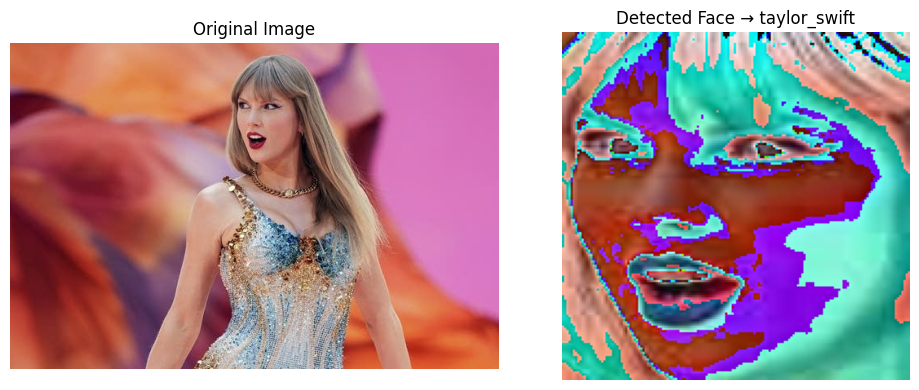

('taylor_swift',
 [('taylor_swift', np.float64(0.31784753672431687)),
  ('emma_watson', np.float64(0.191360992038997)),
  ('kyrie_irving', np.float64(0.17262385337891467)),
  ('stephen_curry', np.float64(0.1659069884905724)),
  ('ariana_grande', np.float64(0.152260629367199))])

In [26]:
dataset = datasets.ImageFolder(cropped_dir, transform=trans)
dataset.idx_to_class = {i: c for c, i in dataset.class_to_idx.items()}
class_embeddings = build_class_embeddings(facenet_model, dataset, device=device)

predict_with_mtcnn(
  test_image_path,
  mtcnn,
  facenet_model,
  class_embeddings,
  device=device
)